<a href="https://colab.research.google.com/github/Epilef86/Recomendacoes_/blob/main/FatoracaoMatrizes_%26_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

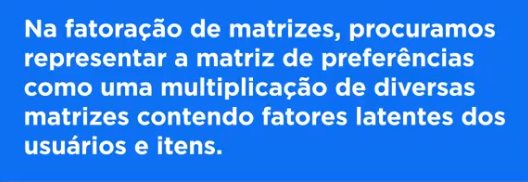

Dado que eu tenha uma matriz R, eu vou aproximar essa matriz como a multiplicação de uma matriz P, aonde essa matriz P tem o fator latente U (usuário) que é um vetor que representa o usuário, pegar essa matriz e multiplicar pela matriz Q, que contém o vetor representativo daquele item. Quando acontece essa multiplicação, eu tenha a matriz de preferências estimadas.


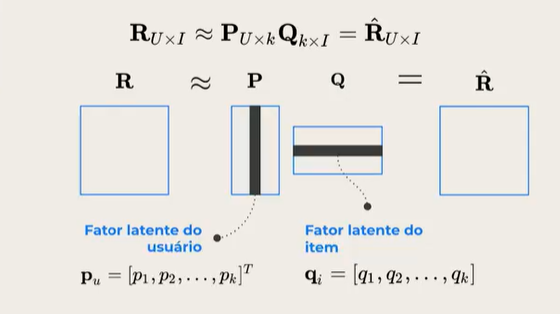

Uma vez que eu tenha esses fatores latentes conseguimos passar esses fatores numa função de transferência F em que passamos o vetor representativo do usuário e do item. Esse modelo vai ter parâmetros treináveis e ai vamos estimar que esse feedback do usuário u pri item i é uma média de notas, se tivermos em um sistema de avaliação com notas

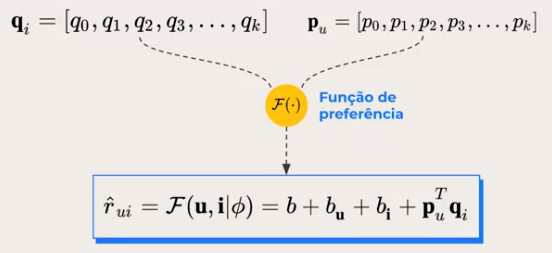

Como estimamos essa matriz p e q ?

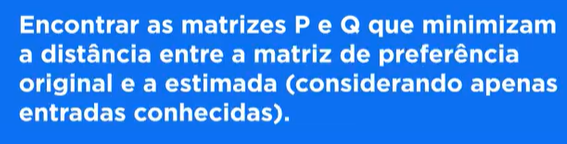

Chamando a matriz de preferência estimada de ^R = PQ. O processo de otimização vai ser igual a minimização dessa diferença entre a matriz original e a matriz estimada mais alguns termos de regularização. Se encontramos as matrizes P e Q que minimizam toda essa equação a gente acha os parametros otimos que indicam os fatores latentes dos usuários e dos itens, então P e Q são os pa^ramtros a serem treinados.

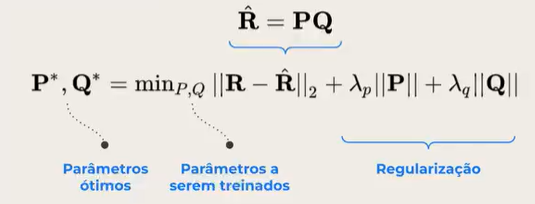

Como encontramos esses parâmetros? usando o algoritmo ALS:

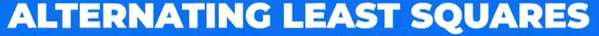

A ideia de algoritmo é treinar uma matriz de cada vez de forma alternada

Então se a gente pega essa equação, essa equação não tem solução analítica se tanto P quanto Q forem variáveis ao mesmo tempo. No entanto uma das ideias que foram utilizadas pra resolver esse problema é fixar uma matriz e resolver o problema com que não foi fixado

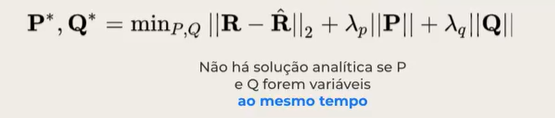

Como que ele funciona? 

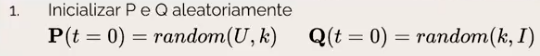

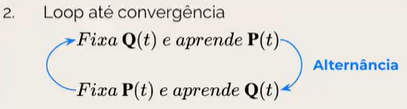

Uma melhoria que foi feito em cima do algoritmo ALS foi o algoritmo SVD

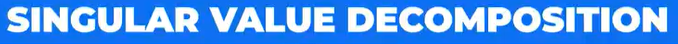

Ele funciona da mesma forma que ALS só que vamos incrementando o número de fatores latentes que são treinados. Primeiro a gente resolve o ALS considerando entre P e Q com dimensão 1, se convergir a gente resolve pra k=2 e assim por diante até o achar o número k de fatores que a gente quer utilizar na solução final

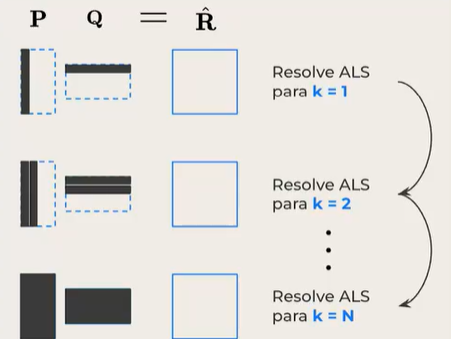

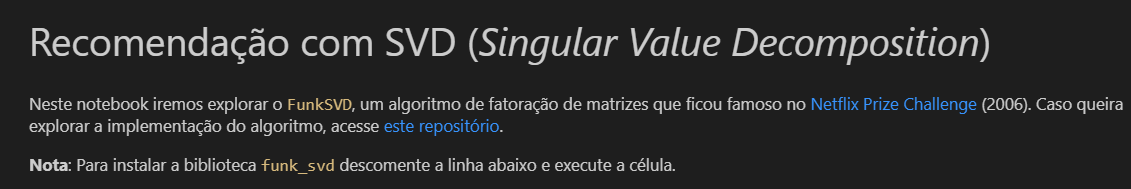

In [1]:
!pip install git+https://github.com/gbolmier/funk-svd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/gbolmier/funk-svd to /tmp/pip-req-build-z6k2u372
  Running command git clone --filter=blob:none --quiet https://github.com/gbolmier/funk-svd /tmp/pip-req-build-z6k2u372
  Resolved https://github.com/gbolmier/funk-svd to commit fecc38ea1c2859ef6a6d9af0b7f953e1b693764e
  Preparing metadata (setup.py) ... done
  Created wheel for funk-svd: filename=funk_svd-0.0.1.dev1-py3-none-any.whl size=9057 sha256=bea8b6f06d906f226779f7fa3064adf250c1330263364251e2319660cd11fe2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-f4lkc0h3/wheels/c1/5f/58/0d631ca5543c40b1e044d2a48dd1a8fbb6a7c189be1141b925
Successfully built funk-svd


In [2]:
import os
import re
import pandas as pd
import numpy as np
from google.colab import files
from funk_svd import SVD
import matplotlib.pyplot as plt
import matplotlib
from cycler import cycler

matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#007efd', '#FFC000', '#303030'])

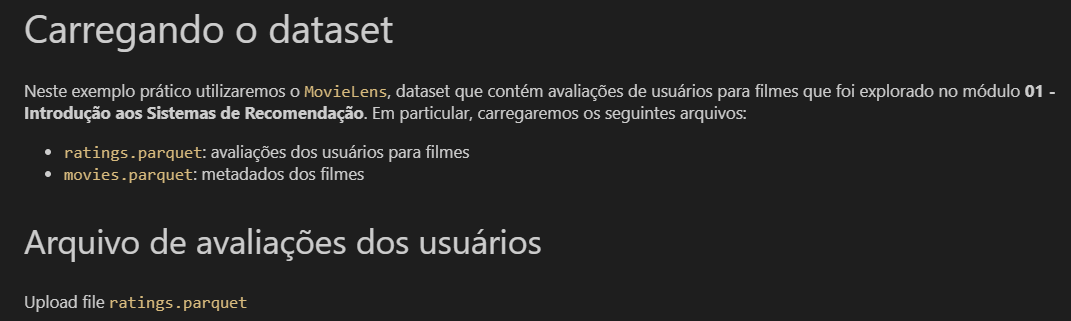

In [3]:
%%time
_ = files.upload() # approx: 1min20s

Saving ratings.parquet to ratings (1).parquet
CPU times: user 1.39 s, sys: 293 ms, total: 1.68 s
Wall time: 1min 25s


In [4]:
df_ratings = pd.read_parquet('ratings.parquet')
df_ratings.tail()

,user_id,item_id,rating,timestamp
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569


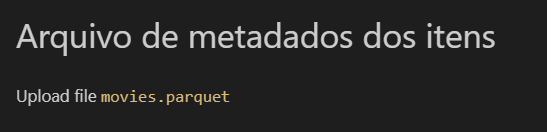

In [5]:
%%time
_ = files.upload() # approx: 10s

Saving movies.parquet to movies (1).parquet
CPU times: user 111 ms, sys: 13.4 ms, total: 125 ms
Wall time: 6.76 s


In [6]:
def extract_year_from_title(title:str, regex='(\d{4})'):
    match = re.search(regex, title)
    return None if match is None else match.group()

def convert_genres_to_list(genres:str, separator='|'):
    return genres.split(separator)

df_items = pd.read_parquet('movies.parquet')
df_items['genres'] = df_items['genres'].apply(convert_genres_to_list)
df_items['year'] = df_items['title'].apply(extract_year_from_title)
df_items.set_index('item_id', inplace=True)
df_items.tail()

,title,genres,year
item_id,,,
3948,Meet the Parents (2000),[Comedy],2000
3949,Requiem for a Dream (2000),[Drama],2000
3950,Tigerland (2000),[Drama],2000
3951,Two Family House (2000),[Drama],2000
3952,"Contender, The (2000)","[Drama, Thriller]",2000


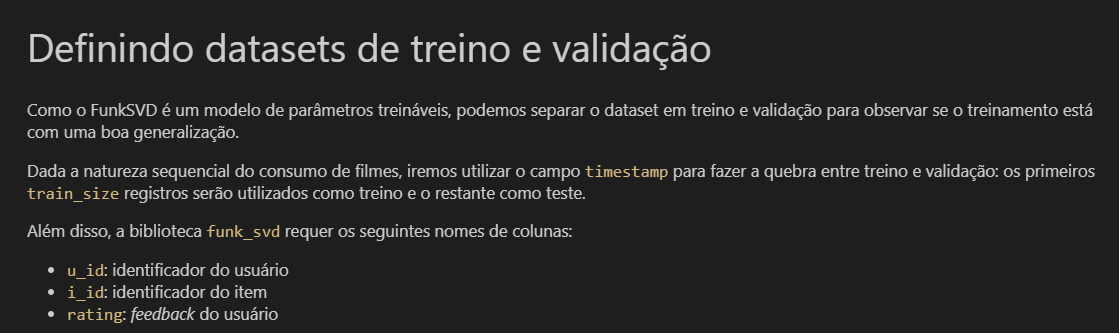

In [7]:
train_size = 0.8
df_ratings.sort_values(by='timestamp', inplace=True)
df_train_set, df_valid_set= np.split(df_ratings, [int(train_size * df_ratings.shape[0])])
df_train_set.rename({'user_id': 'u_id', 'item_id': 'i_id'}, axis = 1, inplace=True)
df_valid_set.rename({'user_id': 'u_id', 'item_id': 'i_id'}, axis = 1, inplace=True)
print ('Train size: ', df_train_set.shape)
print ('Valid size: ', df_valid_set.shape)

Train size:  (800167, 4)
Valid size:  (200042, 4)


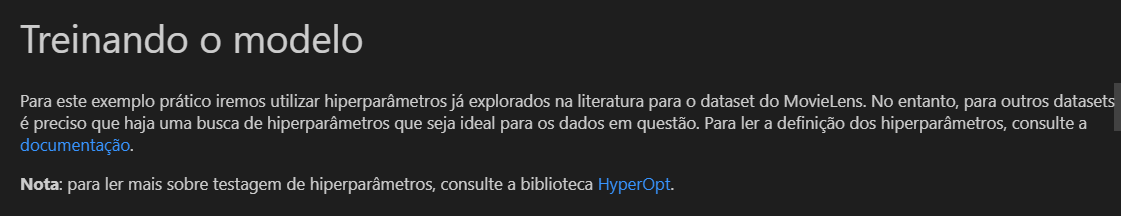

In [8]:
model = SVD(
    lr=0.001, # Learning rate.
    reg=0.005, # L2 regularization factor.
    n_epochs=100, # Number of SGD iterations.
    n_factors=30, # Number of latent factors.
    early_stopping=True, # Whether or not to stop training based on a validation monitoring.
    min_delta=0.0001, # Minimun delta to argue for an improvement.
    shuffle=False, # Whether or not to shuffle the training set before each epoch.
    min_rating=1, # Minimum value a rating should be clipped to at inference time.
    max_rating=5 # Maximum value a rating should be clipped to at inference time.
)
model

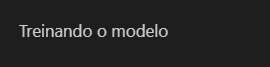

In [9]:
model.fit(X=df_train_set, X_val=df_valid_set)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 1.06 - val_rmse: 1.03 - val_mae: 0.84 - took 1.4 sec
Epoch 2/100  | val_loss: 1.01 - val_rmse: 1.00 - val_mae: 0.81 - took 0.1 sec
Epoch 3/100  | val_loss: 0.98 - val_rmse: 0.99 - val_mae: 0.79 - took 0.1 sec
Epoch 4/100  | val_loss: 0.96 - val_rmse: 0.98 - val_mae: 0.78 - took 0.1 sec
Epoch 5/100  | val_loss: 0.95 - val_rmse: 0.98 - val_mae: 0.77 - took 0.1 sec
Epoch 6/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.77 - took 0.1 sec
Epoch 7/100  | val_loss: 0.94 - val_rmse: 0.97 - val_mae: 0.77 - took 0.1 sec
Epoch 8/100  | val_loss: 0.93 - val_rmse: 0.97 - val_mae: 0.76 - took 0.1 sec
Epoch 9/100  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 10/100 | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 11/100 | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 12/100 | val_loss: 0.92 - val_rmse: 0.96 - val_mae: 0.76 - took 0.1 sec
Epoch 13/100 | val

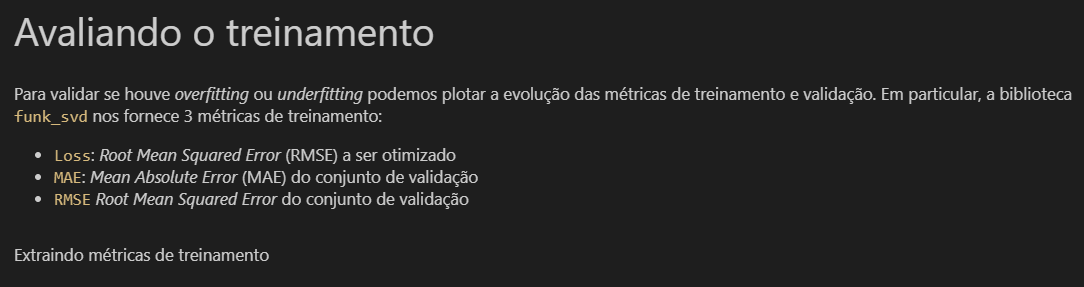

In [10]:
model.metrics_

,Loss,RMSE,MAE
0,1.060662,1.029884,0.835039
1,1.008302,1.004142,0.805285
2,0.981067,0.990488,0.789646
3,0.964209,0.981941,0.780103
4,0.952707,0.976067,0.773690
...,...,...,...
63,0.888430,0.942566,0.742545
64,0.888201,0.942444,0.742492
65,0.887993,0.942334,0.742449
66,0.887805,0.942234,0.742414


Vemos no gráfico abaixo que o eixo X é a época e Y o valor métrica. Percebemos que com o passar das épocas essas métricas vão convergindo pra um determindo valor. Isso indica que não é tão interessante continuar treinando o modelo depois dessa épocas pq vamos ter um ganho muito pequeno. Geralmente esse gráfico é utilizado pra ver se o modelo está tendo overfit ou underfit. Como a métrica se estabilizou e não teve uma diferença muito grande entre a Loss e as métricas de validação vamos considerar que o treinamento foi bem feito.

(<Figure size 1152x576 with 1 Axes>,
 <Axes: title={'center': 'SVD train and valid metrics (67 epochs)'}, xlabel='Epoch'>)

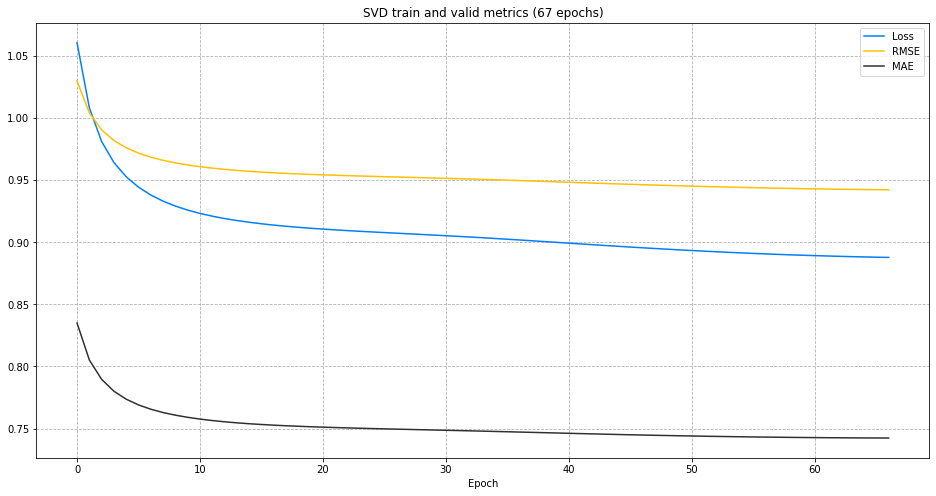

In [11]:
def plot_metrics_evolution(metrics:pd.DataFrame, figsize=(16,8)):
    fig, ax = plt.subplots(figsize=figsize)
    for metric_name in metrics.columns:
        ax.plot(metrics[metric_name], label=metric_name)
    ax.set_title(f'SVD train and valid metrics ({metrics.shape[0]} epochs)')
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.grid(True, linestyle='--')

    return fig, ax

plot_metrics_evolution(model.metrics_.head(-1))

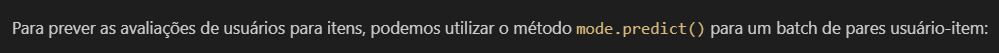

In [12]:
df_valid_set['prediction'] = model.predict(df_valid_set)
df_valid_set.head()

,u_id,i_id,rating,timestamp,prediction
314160,1875,1721,4,975768738,3.532717
314032,1875,2621,4,975768748,3.599910
94555,635,3095,5,975768756,4.447773
94640,635,36,5,975768756,4.402414
94578,635,608,5,975768756,4.340626


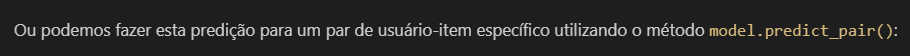

In [13]:
item_id = 1721
user_id = 1875

In [14]:
def get_user_item_prediction(model, user_id, item_id):
    prediction = model.predict_pair(user_id, item_id)
    return prediction

prediction = get_user_item_prediction(model, user_id, item_id)
print (f'Prediction for user {user_id} to item {item_id}: {prediction}')
df_valid_set.query('u_id == @user_id and i_id == @item_id')

Prediction for user 1875 to item 1721: 3.5327167536164152


,u_id,i_id,rating,timestamp,prediction
314160,1875,1721,4,975768738,3.532717


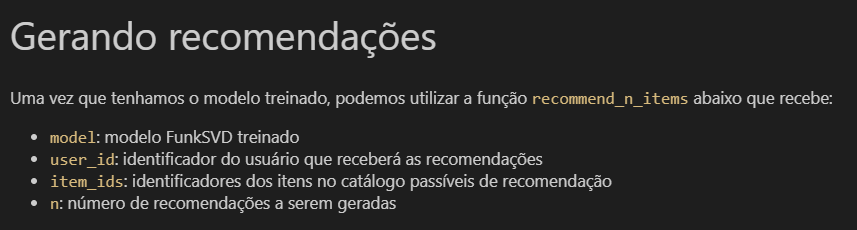

In [15]:
def recommend_n_items(model, user_id, item_ids:np.array, n=20):
    df_predictions = pd.DataFrame()
    df_predictions['i_id'] = item_ids
    df_predictions['u_id'] = user_id
    df_predictions['score'] = model.predict(df_predictions)

    user_predictions = (
        df_predictions
        .sort_values(by='score', ascending=False)
        .rename({'u_id': 'user_id', 'i_id': 'item_id'}, axis=1)
        .set_index('item_id')
    )

    return user_predictions.head(n)

item_ids = df_valid_set['i_id'].unique()
user_recommendations = recommend_n_items(model, user_id, item_ids, n=10)
user_recommendations

,user_id,score
item_id,,
1,1875,4.741145
919,1875,4.728877
1207,1875,4.704750
1148,1875,4.635592
527,1875,4.625684
1307,1875,4.568160
2019,1875,4.534325
3114,1875,4.531299
899,1875,4.530006


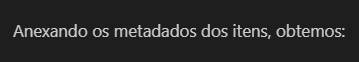

In [16]:
user_recommendations.merge(df_items, left_index=True, right_index=True)

,user_id,score,title,genres,year
item_id,,,,,
1,1875,4.741145,Toy Story (1995),"[Animation, Children's, Comedy]",1995
919,1875,4.728877,"Wizard of Oz, The (1939)","[Adventure, Children's, Drama, Musical]",1939
1207,1875,4.704750,To Kill a Mockingbird (1962),[Drama],1962
1148,1875,4.635592,"Wrong Trousers, The (1993)","[Animation, Comedy]",1993
527,1875,4.625684,Schindler's List (1993),"[Drama, War]",1993
1307,1875,4.568160,When Harry Met Sally... (1989),"[Comedy, Romance]",1989
2019,1875,4.534325,Seven Samurai (The Magnificent Seven) (Shichin...,"[Action, Drama]",1954
3114,1875,4.531299,Toy Story 2 (1999),"[Animation, Children's, Comedy]",1999
899,1875,4.530006,Singin' in the Rain (1952),"[Musical, Romance]",1952


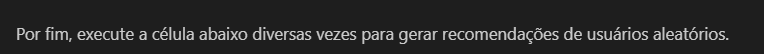

In [17]:
random_user_id = df_ratings['user_id'].sample().tolist()[0]
print (f'Recommendations for user {random_user_id}')
user_recommendations = recommend_n_items(model, random_user_id, item_ids, n=20)
user_recommendations.merge(df_items, left_index=True, right_index=True)

Recommendations for user 5254


,user_id,score,title,genres,year
item_id,,,,,
356,5254,4.844397,Forrest Gump (1994),"[Comedy, Romance, War]",1994
318,5254,4.744496,"Shawshank Redemption, The (1994)",[Drama],1994
3578,5254,4.692030,Gladiator (2000),"[Action, Drama]",2000
110,5254,4.690886,Braveheart (1995),"[Action, Drama, War]",1995
527,5254,4.670908,Schindler's List (1993),"[Drama, War]",1993
2028,5254,4.663986,Saving Private Ryan (1998),"[Action, Drama, War]",1998
260,5254,4.553435,Star Wars: Episode IV - A New Hope (1977),"[Action, Adventure, Fantasy, Sci-Fi]",1977
1036,5254,4.540932,Die Hard (1988),"[Action, Thriller]",1988
2762,5254,4.521014,"Sixth Sense, The (1999)",[Thriller],1999


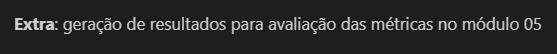

In [18]:
from tqdm import tqdm
model_name = 'svd'
n = 20
catalog = df_items.index.values
df_recommendations = pd.DataFrame()
for user_id in tqdm(df_valid_set['u_id'].unique()):
  user_known_items = df_train_set.query('u_id == @user_id')['i_id'].unique()
  recommendable_items = np.array(list(set(catalog)-set(user_known_items)))
  user_recommendations = recommend_n_items(model, user_id, recommendable_items, n).reset_index(drop=False)
  user_recommendations['user_id'] = user_id
  df_recommendations = pd.concat([df_recommendations, user_recommendations])

df_recommendations['y_score'] = df_recommendations.apply(lambda x: {'item_id': x['item_id'], 'score': x['score']}, axis=1)
df_recommendations = df_recommendations.groupby('user_id').agg({'y_score': list}).reset_index(drop=False)
df_recommendations.tail()


100%|██████████| 1783/1783 [01:00<00:00, 29.46it/s]


,user_id,y_score
1778,6001,"[{'item_id': 1247.0, 'score': 4.66636283842841..."
1779,6002,"[{'item_id': 2019.0, 'score': 4.88653712062993..."
1780,6016,"[{'item_id': 745.0, 'score': 4.319552161217432..."
1781,6028,"[{'item_id': 2609.0, 'score': 4.30561596237544..."
1782,6040,"[{'item_id': 2908.0, 'score': 4.51256297620617..."


In [ ]:
df_predictions = df_valid_set.rename({'u_id': 'user_id', 'i_id': 'item_id'}, axis=1)
df_predictions['y_true'] = df_predictions.apply(lambda x: {'item_id': x['item_id'], 'rating': x['rating']}, axis=1)
df_predictions = df_predictions.groupby('user_id').agg({'y_true': list}).reset_index(drop=False)
df_predictions = df_predictions.merge(df_recommendations, on='user_id', how='inner')
df_predictions['model'] = model_name
df_predictions.tail()

In [ ]:
column_order = ['model', 'user_id', 'y_true', 'y_score']
df_predictions[column_order].to_parquet(f'valid_{model_name}.parquet', index=None)